In [1]:
import pennylane as qml
import pennylane.numpy as np
from pyscf import gto, scf, ci
from pennylane.qchem import import_state
from functools import partial
import matplotlib.pyplot as plt

[1 1 1 1 0 0 0 0 0 0 0 0]
Step = 0,  E = -1.96147770 Ha,  bond length = 0.86801 A
Step = 4,  E = -2.17175667 Ha,  bond length = 0.70675 A
Step = 8,  E = -2.19577425 Ha,  bond length = 0.70655 A
Step = 12,  E = -2.20669813 Ha,  bond length = 0.70736 A
Step = 16,  E = -2.21294439 Ha,  bond length = 0.70801 A
Step = 20,  E = -2.21698191 Ha,  bond length = 0.70851 A
Step = 24,  E = -2.21980186 Ha,  bond length = 0.70891 A
Step = 28,  E = -2.22187998 Ha,  bond length = 0.70923 A
Step = 32,  E = -2.22347309 Ha,  bond length = 0.70949 A
Step = 36,  E = -2.22473197 Ha,  bond length = 0.70971 A
Step = 40,  E = -2.22575097 Ha,  bond length = 0.70990 A
Step = 44,  E = -2.22659209 Ha,  bond length = 0.71007 A
Step = 48,  E = -2.22729772 Ha,  bond length = 0.71021 A

Final value of the ground-state energy = -2.22745668 Ha

Ground-state equilibrium geometry
symbol    x        y        z
  H    -0.8248   0.7551   -0.0003
  H    -0.1070   1.8892   -0.0004
  H    2.6022   -0.6079   -0.0007
  H    3.917

/tmp/ipykernel_7608/567158559.py:94: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(range(n + 1), E_vqe - E_fci, "go-", ls="dashed")
/tmp/ipykernel_7608/567158559.py:106: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")


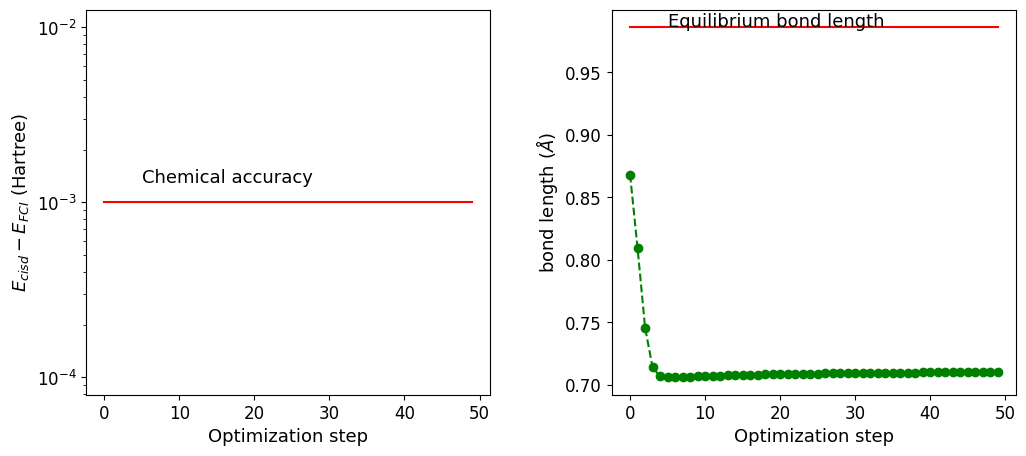

In [2]:
symbols = ["H", "H", "H", "H"]
x = np.array([0.028, 0.054, 0.0, 0.986, 1.610, 0.0, 1.855, 0.002, 0.0, 2.719, 0.0, 0.002], requires_grad=True)

def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0)[0]

hf = qml.qchem.hf_state(electrons=4, orbitals=12)
print(hf)

num_wires = 12
dev = qml.device("lightning.qubit", wires=num_wires)

@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
    qml.DoubleExcitation(params[1], wires=[4, 5, 6, 7])
    qml.DoubleExcitation(params[2], wires=[8, 9, 10, 11])

    return qml.expval(obs)

def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []

    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1
        gradient.append(res)

    return gradient

def grad_x(params, x):
    grad_h = finite_diff(H, x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

opt_theta = qml.GradientDescentOptimizer(stepsize=0.8)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

theta = np.array([0.0, 0.0, 0.0], requires_grad=True)

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(50):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-04:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")


fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
E_fci = -1.27443765658
E_vqe = np.array(energy)
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 1), E_vqe - E_fci, "go-", ls="dashed")
ax1.plot(range(n + 1), np.full(n + 1, 0.001), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{cisd} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(5, 0.0013, r"Chemical accuracy", fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 0.986
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")
ax2.plot(range(n + 1), np.full(n + 1, d_fci), color="red")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
ax2.text(5, 0.9865, r"Equilibrium bond length", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()


In [3]:
# Setting up CISD-based state vector
mol = gto.M(atom=[
    ["H", [0.028, 0.054, 0.0]],
    ["H", [0.986, 1.610, 0.0]],
    ["H", [1.855, 0.002, 0.0]],
    ["H", [2.719, 0.0, 0.002]]
], charge=0)
myhf = scf.RHF(mol).run()
myci = ci.CISD(myhf).run()
wf_cisd = import_state(myci, tol=1e-1)

@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    qml.QubitStateVector(wf_cisd, wires=range(num_wires))
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
    qml.DoubleExcitation(params[1], wires=[4, 5, 6, 7])
    qml.DoubleExcitation(params[2], wires=[8, 9, 10, 11])

    return qml.expval(obs)

def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []

    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1
        gradient.append(res)

    return gradient

opt_theta = qml.GradientDescentOptimizer(stepsize=0.8)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

theta = np.array([0.0, 0.0], requires_grad=True)

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(50):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-04:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
E_fci = -1.27443765658
E_cisd = np.array(energy)
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 1), E_cisd - E_fci, "go-", ls="dashed")
ax1.plot(range(n + 1), np.full(n + 1, 0.001), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{cisd} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(5, 0.0013, r"Chemical accuracy", fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 0.986
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")
ax2.plot(range(n + 1), np.full(n + 1, d_fci), color="red")
ax2.set_ylim([0.965, 0.99])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
ax2.text(5, 0.9865, r"Equilibrium bond length", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()


converged SCF energy = -1.90628398469122
E(RCISD) = -2.063714589679847  E_corr = -0.1574306049886245


ValueError: State vector must have shape (2**wires,) or (batch_size, 2**wires).

In [ ]:
fig, ax3 = plt.subplots(figsize=(10, 6))

# Plot VQE energy
ax3.plot(range(len(E_vqe)), E_vqe, label="VQE Energy", color="darkviolet")

# Plot CISD energy
ax3.plot(range(len(E_cisd)), np.full(len(E_cisd), E_cisd), label="CISD Energy", color="rebeccapurple")

# Plot FCI energy as a horizontal line
ax3.axhline(y=E_fci, linestyle="--", label="FCI Energy", color="dodgerblue")

ax3.set_xlabel("Optimization step", fontsize=13)
ax3.set_ylabel("Energy (Hartree)", fontsize=13)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
fig, ax3 = plt.subplots(figsize=(10, 6))

# Plot VQE energy
ax3.plot(range(len(E_vqe)), E_vqe - E_fci, label="VQE Energy", color="darkviolet")

# Plot CISD energy
ax3.plot(range(len(E_cisd)), np.full(len(E_cisd), E_cisd - E_fci), label="CISD Energy", color="rebeccapurple")

# Plot FCI energy as a horizontal line
ax3.axhline(y=E_fci, linestyle="--", label="FCI Energy", color="dodgerblue")

ax3.set_xlabel("Optimization step", fontsize=13)
ax3.set_ylabel("Energy (Hartree)", fontsize=13)
ax3.set_xlim([0, 20])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 1), E_vqe - E_fci, "go-", ls="dashed")
ax1.plot(range(n + 1), np.full(n + 1, 0.001), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{cisd} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(5, 0.0013, r"Chemical accuracy", fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 0.986
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")
ax2.plot(range(n + 1), np.full(n + 1, d_fci), color="red")
ax2.set_ylim([0.965, 0.99])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
ax2.text(5, 0.9865, r"Equilibrium bond length", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()
